《悲惨世界》人物关系-Node2Vec图嵌入


Elior Cohen代码：https://github.com/eliorc/node2vec

Elior Cohen代码博客：https://maelfabien.github.io/machinelearning/graph_5/#graph-embedding

同济子豪兄：https://space.bilibili.com/1900783

2022-6-29

安装工具包

 导入工具包

In [3]:
import networkx as nx # 图数据挖掘
import numpy as np # 数据分析
import random # 随机数

# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

导入数据集

In [2]:
# 空手道俱乐部数据集
# G = nx.karate_club_graph()

In [4]:
# 《悲惨世界》人物数据集
G = nx.les_miserables_graph()

In [5]:
G.nodes

NodeView(('Napoleon', 'Myriel', 'MlleBaptistine', 'MmeMagloire', 'CountessDeLo', 'Geborand', 'Champtercier', 'Cravatte', 'Count', 'OldMan', 'Valjean', 'Labarre', 'Marguerite', 'MmeDeR', 'Isabeau', 'Gervais', 'Listolier', 'Tholomyes', 'Fameuil', 'Blacheville', 'Favourite', 'Dahlia', 'Zephine', 'Fantine', 'MmeThenardier', 'Thenardier', 'Cosette', 'Javert', 'Fauchelevent', 'Bamatabois', 'Perpetue', 'Simplice', 'Scaufflaire', 'Woman1', 'Judge', 'Champmathieu', 'Brevet', 'Chenildieu', 'Cochepaille', 'Pontmercy', 'Boulatruelle', 'Eponine', 'Anzelma', 'Woman2', 'MotherInnocent', 'Gribier', 'MmeBurgon', 'Jondrette', 'Gavroche', 'Gillenormand', 'Magnon', 'MlleGillenormand', 'MmePontmercy', 'MlleVaubois', 'LtGillenormand', 'Marius', 'BaronessT', 'Mabeuf', 'Enjolras', 'Combeferre', 'Prouvaire', 'Feuilly', 'Courfeyrac', 'Bahorel', 'Bossuet', 'Joly', 'Grantaire', 'MotherPlutarch', 'Gueulemer', 'Babet', 'Claquesous', 'Montparnasse', 'Toussaint', 'Child1', 'Child2', 'Brujon', 'MmeHucheloup'))

In [6]:
len(G)

77

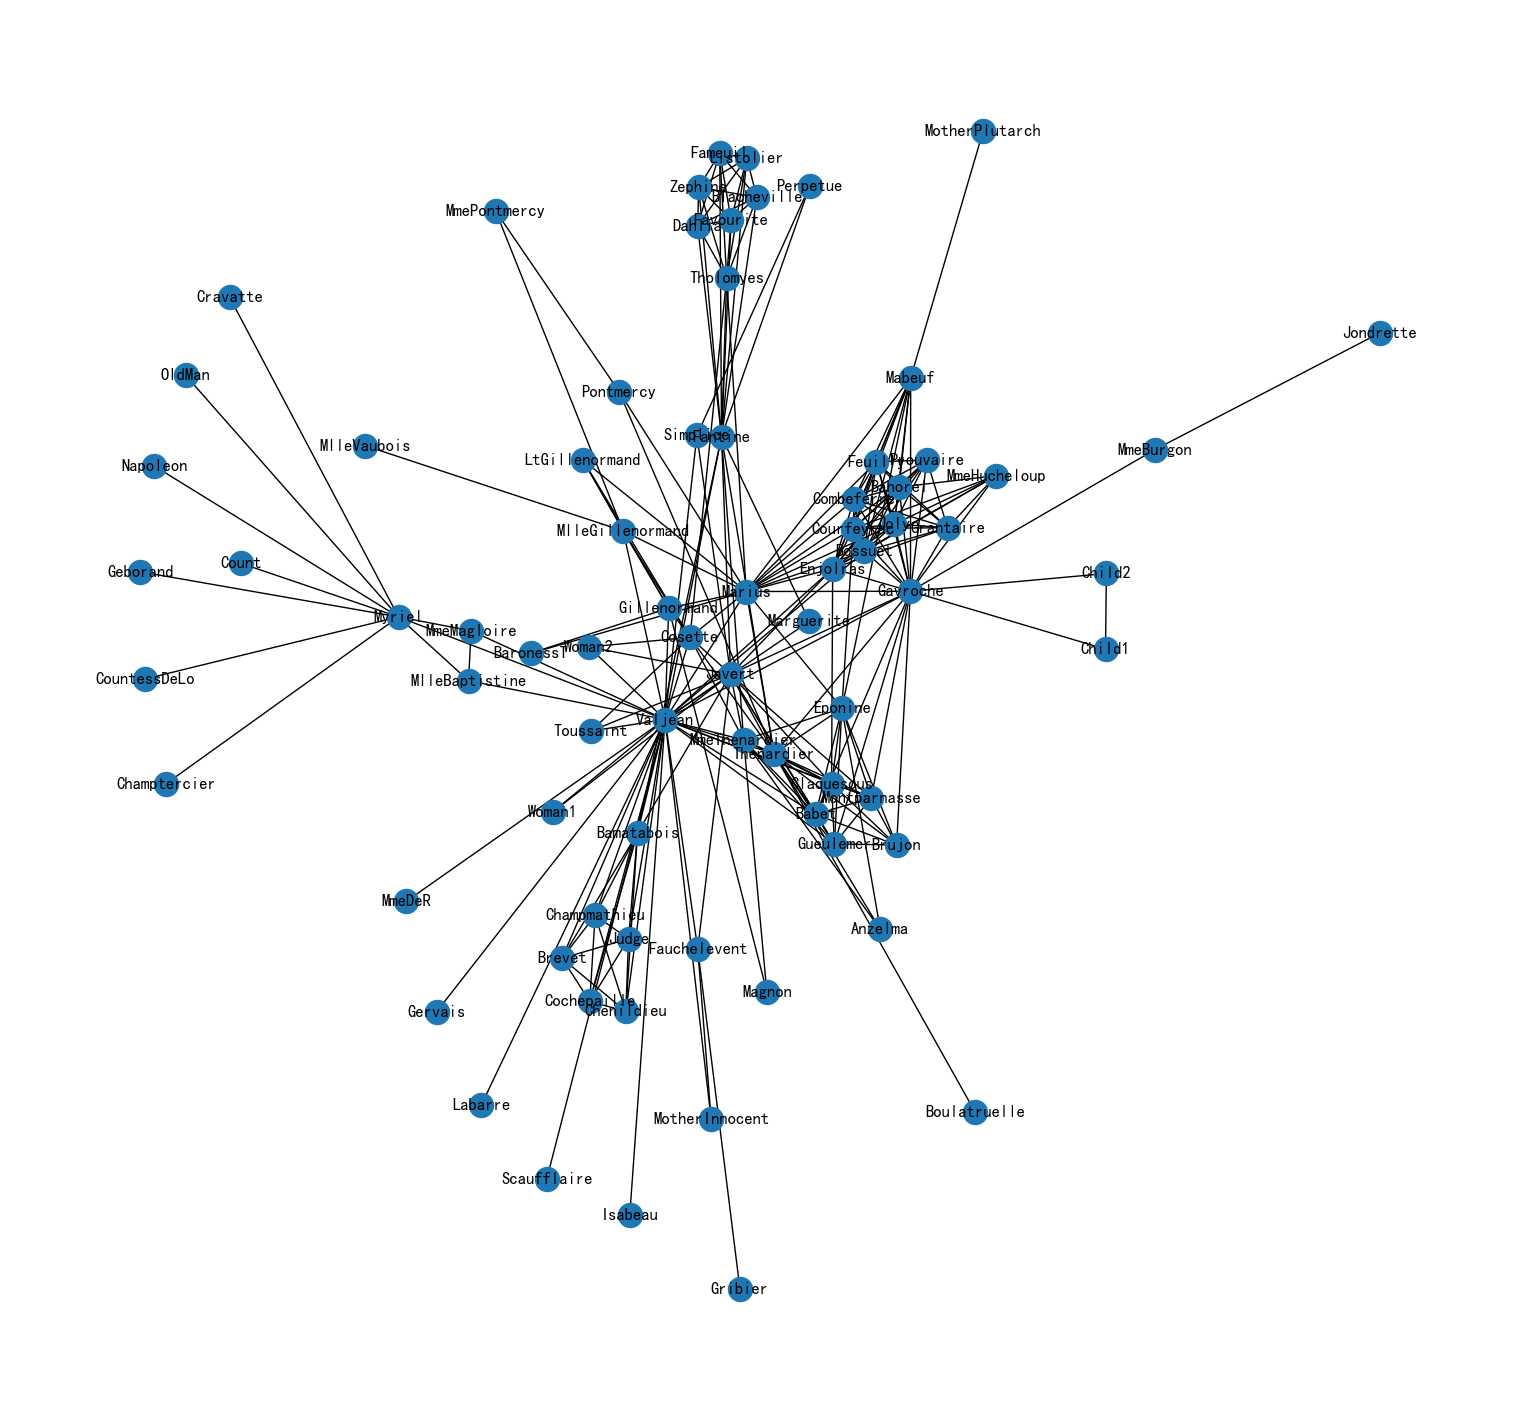

In [7]:
# 可视化
plt.figure(figsize=(15,14))
pos = nx.spring_layout(G, seed=5)
nx.draw(G, pos, with_labels=True)
plt.show()

## 构建Node2Vec模型

In [8]:
from node2vec import Node2Vec

In [9]:
# 设置node2vec参数
node2vec = Node2Vec(G, 
                    dimensions=32,  # 嵌入维度
                    p=1,            # 回家参数
                    q=3,          # 外出参数
                    walk_length=10, # 随机游走最大长度
                    num_walks=600,  # 每个节点作为起始节点生成的随机游走个数
                    workers=4       # 并行线程数
                   )

# p=1, q=0.5, n_clusters=6。DFS深度优先搜索，挖掘同质社群
# p=1, q=2, n_clusters=3。BFS宽度优先搜索，挖掘节点的结构功能。

# 训练Node2Vec，参数文档见 gensim.models.Word2Vec
model = node2vec.fit(window=3,    # Skip-Gram窗口大小
                     min_count=1,  # 忽略出现次数低于此阈值的节点（词）
                     batch_words=4 # 每个线程处理的数据量
                    )
X = model.wv.vectors

Computing transition probabilities:   0%|          | 0/77 [00:00<?, ?it/s]

In [10]:
X.shape

(77, 32)

## 节点Embedding聚类可视化

### 运行聚类

Kmeans聚类算法讲解：https://www.bilibili.com/video/BV1HJ411P7cs

In [11]:
# # DBSCAN聚类
# from sklearn.cluster import DBSCAN
# cluster_labels = DBSCAN(eps=0.5, min_samples=6).fit(X).labels_
# print(cluster_labels)

# KMeans聚类
from sklearn.cluster import KMeans
import numpy as np
cluster_labels = KMeans(n_clusters=3).fit(X).labels_
print(cluster_labels)

[0 0 0 0 1 0 0 0 2 0 0 0 0 1 1 0 0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 1 1 0 1 0 1
 1 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 2 0 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0]


### 将networkx中的节点和词向量中的节点对应

将词汇表的节点顺序转为networkx中的节点顺序

In [12]:
colors = []
nodes = list(G.nodes)
for node in nodes: # 按 networkx 的顺序遍历每个节点
    idx = model.wv.key_to_index[str(node)] # 获取这个节点在 embedding 中的索引号
    colors.append(cluster_labels[idx]) # 获取这个节点的聚类结果

### 可视化聚类效果

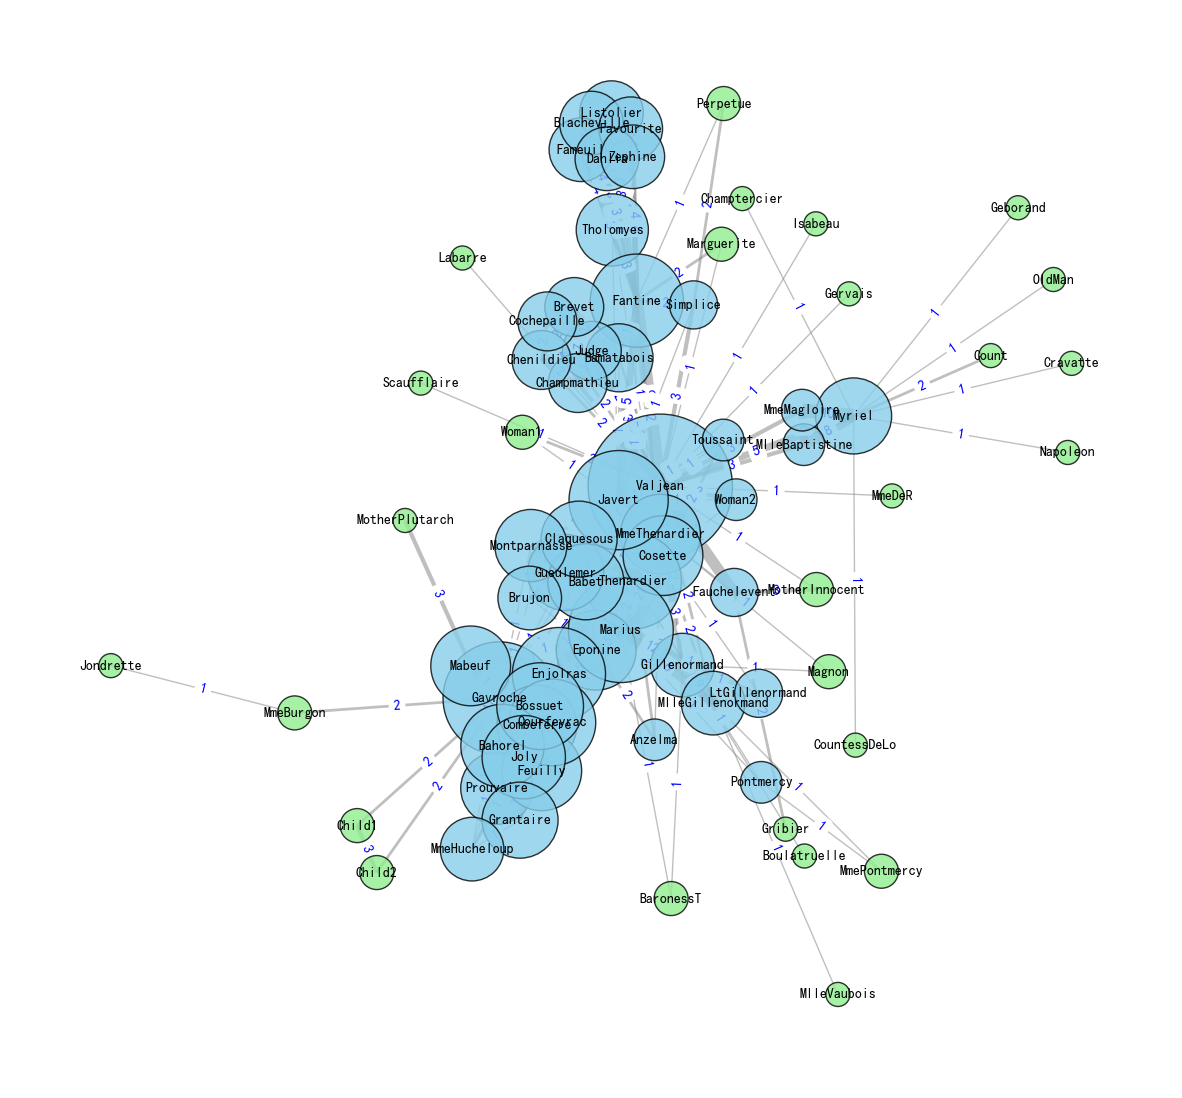

In [14]:
node_sizes = [len(G[node]) * 300 for node in G.nodes()]  # 根据节点的度设置大小
node_colors = ['skyblue' if G.degree(node) > 2 else 'lightgreen' for node in G.nodes()]  # 根据度数设置颜色

# 绘制图的大小
plt.figure(figsize=(15, 14))

# 设置布局 - spring layout 通常效果较好，但可以根据图形大小选择其他布局
pos = nx.spring_layout(G, seed=10, k=0.3)  # k 值控制节点之间的距离，调整视觉效果

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, edgecolors="black")

# 绘制边
edge_weights = [G[u][v].get('weight', 1.0) for u, v in G.edges()]  # 使用边的权重调整线条粗细
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray', alpha=0.5, style='solid')

# 绘制标签
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_family='sans-serif', font_weight='bold')

# 让边的标签更加美观，若边有权重可以显示出来
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')

# 移除轴线
plt.axis('off')

# 显示图形
plt.show()



## 节点Embedding降维可视化

In [15]:
# 将Embedding用PCA降维到2维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

# # 将Embedding用TSNE降维到2维
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, n_iter=5000)
# embed_2d = tsne.fit_transform(X)

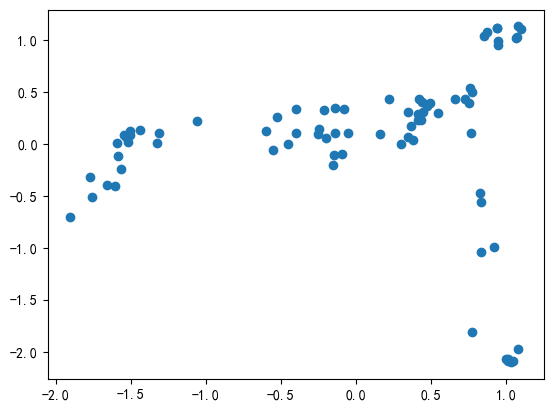

In [16]:
# plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

## 查看Embedding

In [17]:
model.wv.get_vector('Napoleon').shape

(32,)

In [19]:
# 查看某个节点的Embedding
model.wv.get_vector('Napoleon')

array([-0.37893724, -0.18088876,  0.95714414, -0.47144073,  0.07708214,
       -0.40302926,  0.59880066,  0.8617101 , -0.48096886,  0.11440159,
        0.4375238 , -0.22644798, -0.06394124, -0.09356706,  0.39879867,
       -0.24388759,  0.01027475, -0.07842625,  0.73053694,  0.08503655,
        0.11347196,  0.97009623,  0.57194614,  0.04221683,  0.11664093,
        0.21153598, -0.40272132,  0.6452216 ,  0.7083464 ,  0.13926497,
        0.4152877 ,  0.11475262], dtype=float32)

In [20]:
# 查找 Napoleon 节点的相似节点
model.wv.most_similar('Napoleon')

[('Geborand', 0.9637594223022461),
 ('CountessDeLo', 0.9546518325805664),
 ('OldMan', 0.9511183500289917),
 ('Cravatte', 0.9492028951644897),
 ('Champtercier', 0.9467245936393738),
 ('MmeMagloire', 0.9083477258682251),
 ('MlleBaptistine', 0.8987857103347778),
 ('Count', 0.8862771391868591),
 ('Myriel', 0.874491274356842),
 ('Valjean', 0.4502852261066437)]

In [36]:
# 按相似度（元组的第二个元素）进行降序排序
list = sorted(model.wv.similar_by_word('Napoleon'), key=lambda x: x[1], reverse=False)

# 打印排序后的相似度
for i in list:
    print(f"Word: {i[0]}, Similarity: {i[1]}")


Word: Valjean, Similarity: 0.4502852261066437
Word: Myriel, Similarity: 0.874491274356842
Word: Count, Similarity: 0.8862771391868591
Word: MlleBaptistine, Similarity: 0.8987857103347778
Word: MmeMagloire, Similarity: 0.9083477258682251
Word: Champtercier, Similarity: 0.9467245936393738
Word: Cravatte, Similarity: 0.9492028951644897
Word: OldMan, Similarity: 0.9511183500289917
Word: CountessDeLo, Similarity: 0.9546518325805664
Word: Geborand, Similarity: 0.9637594223022461


In [22]:
# 查看任意两个节点的相似度
model.wv.similarity('Napoleon', 'Champtercier')

0.9467246

In [20]:
# 查看任意两个节点的相似度
model.wv.similarity('Napoleon', 'Brujon')

0.17977357

## 对Edge（连接）做Embedding

In [21]:
from node2vec.edges import HadamardEmbedder

In [22]:
# Hadamard 二元操作符：两个 Embedding 对应元素相乘
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [23]:
# 查看 任意两个节点连接 的 Embedding
edges_embs[('Napoleon', 'Champtercier')]

array([ 0.15775563,  0.01358349,  0.3162558 ,  0.5411846 ,  0.22546816,
        0.7466963 , -0.005813  ,  0.86835414, -0.00195181,  0.02421439,
        0.18459085,  0.3095124 ,  0.12261241, -0.00222544,  0.0279634 ,
        0.29843694,  0.00749079,  0.6890226 ,  0.00969159,  0.02298461,
        0.01657523,  0.40088785,  0.5472229 ,  0.22391982,  0.10166607,
        0.21445681, -0.00158626,  0.5742762 ,  0.0050501 ,  0.00760128,
        0.00726296,  0.00317552], dtype=float32)

In [24]:
# 计算所有 Edge 的 Embedding
edges_kv = edges_embs.as_keyed_vectors()

Generating edge features: 100%|██████████| 3003/3003.0 [00:00<00:00, 404064.38it/s]


In [25]:
edges_kv.index_to_key

["('Valjean', 'Valjean')",
 "('Marius', 'Valjean')",
 "('Cosette', 'Valjean')",
 "('Thenardier', 'Valjean')",
 "('Myriel', 'Valjean')",
 "('Enjolras', 'Valjean')",
 "('Courfeyrac', 'Valjean')",
 "('Javert', 'Valjean')",
 "('Gavroche', 'Valjean')",
 "('Fantine', 'Valjean')",
 "('Bossuet', 'Valjean')",
 "('Combeferre', 'Valjean')",
 "('MmeMagloire', 'Valjean')",
 "('MmeThenardier', 'Valjean')",
 "('Gillenormand', 'Valjean')",
 "('MlleBaptistine', 'Valjean')",
 "('Joly', 'Valjean')",
 "('Babet', 'Valjean')",
 "('MlleGillenormand', 'Valjean')",
 "('Bahorel', 'Valjean')",
 "('Gueulemer', 'Valjean')",
 "('Feuilly', 'Valjean')",
 "('Favourite', 'Valjean')",
 "('Dahlia', 'Valjean')",
 "('Tholomyes', 'Valjean')",
 "('Blacheville', 'Valjean')",
 "('Valjean', 'Zephine')",
 "('Fameuil', 'Valjean')",
 "('Listolier', 'Valjean')",
 "('Claquesous', 'Valjean')",
 "('Fauchelevent', 'Valjean')",
 "('Judge', 'Valjean')",
 "('Champmathieu', 'Valjean')",
 "('Eponine', 'Valjean')",
 "('Cochepaille', 'Valjean

In [26]:
# 查看 关系与 某两个节点 最相似的 节点对
edges_kv.most_similar(str(('Bossuet', 'Valjean')))


[("('Bahorel', 'Valjean')", 0.9482592344284058),
 ("('Prouvaire', 'Valjean')", 0.9082643985748291),
 ("('Combeferre', 'Valjean')", 0.8978522419929504),
 ("('Feuilly', 'Valjean')", 0.8943434953689575),
 ("('Joly', 'Valjean')", 0.8787540793418884),
 ("('Courfeyrac', 'Valjean')", 0.8748489618301392),
 ("('Enjolras', 'Valjean')", 0.8706992864608765),
 ("('Enjolras', 'Marguerite')", 0.8387609124183655),
 ("('Grantaire', 'Valjean')", 0.8354304432868958),
 ("('Combeferre', 'Marguerite')", 0.8238444328308105)]

In [48]:
#h猴子排序
import random

# 判断列表是否已经排序
def is_sorted(arr):
    for i in range(len(arr) - 1):
        if arr[i] > arr[i + 1]:
            return False
    return True

# 猴子排序算法
def bogosort(arr):
    attempts = 0  # 计数打乱的次数
    while not is_sorted(arr):
        random.shuffle(arr)  # 随机打乱顺序
        attempts += 1
    print(f"Array sorted after {attempts} attempts.")
    return arr

# 测试猴子排序算法
arr = [5, 2, 9, 1, 5, 6,]
print("Original array:", arr)
sorted_arr = bogosort(arr)
print("Sorted array:", sorted_arr)


Original array: [5, 2, 9, 1, 5, 6]
Array sorted after 339 attempts.
Sorted array: [1, 2, 5, 5, 6, 9]
